In [1]:
import pandas as pd

# Load the dataset from the GitHub repository
url = 'https://raw.githubusercontent.com/gregversteeg/LinearCorex/master/tests/data/test_big5.csv'
df = pd.read_csv(url)

# Display basic information about the dataset
print("Number of instances in the dataset:", df.shape[0])
print("Number of columns in the dataset:", df.shape[1])
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Display additional information
print("\nData Types and Non-Null Counts:")
print(df.info())

Number of instances in the dataset: 2000
Number of columns in the dataset: 50

First 5 rows of the dataset:
   blue_q0  red_q1  green_q2  purple_q3  q4  blue_q5  red_q6  green_q7  \
0        2       0         3          1   4        1       4         1   
1        2       0         1          2   2        1       4         3   
2        3       0         2          1   3        1       4         3   
3        2       0         1          1   1        0       4         1   
4        2       0         1          1   3        0       4         3   

   purple_q8  q9  ...  blue_q40  red_q41  green_q42  purple_q43  q44  \
0          2   2  ...         3        3          3           2    3   
1          3   1  ...         2        3          2           2    3   
2          3   0  ...         4        4          2           1    4   
3          3   1  ...         1        2          2           1    3   
4          2   0  ...         3        4          1           3    4   

   blue_q45  r

In [2]:
# Identify column prefixes for each true factor
factor_columns = {
    'Factor1': [col for col in df.columns if col.startswith('blue')],
    'Factor2': [col for col in df.columns if col.startswith('green')],
    'Factor3': [col for col in df.columns if col.startswith('purple')],
    'Factor4': [col for col in df.columns if col.startswith('red')],
    'Factor5': [col for col in df.columns if col.startswith('q')]
}

# Calculate true factors by summing the respective columns
true_factors = pd.DataFrame()
for factor_name, columns in factor_columns.items():
    true_factors[factor_name] = df[columns].sum(axis=1)

# Display the first few rows of the calculated true factors
print(true_factors.head())

   Factor1  Factor2  Factor3  Factor4  Factor5
0       20       21       21       22       28
1       21       20       21       26       23
2       23       20       17       22       25
3       17       15       11       22       15
4       20       14       24       23       24


In [3]:
df = df / 4.0
# print(df.head())

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Split the data into features (X) and target (Y) if necessary.
# In the case of autoencoder-like models, we do not have target Y, so we'll treat the whole dataset as X.
X = df.values  # Convert the DataFrame into a NumPy array for model input

# Split the dataset into training (80%) and testing sets (20%)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Output the shapes to verify
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (1600, 50)
Test set shape: (400, 50)


In [5]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

# Assuming X_train and X_test are your training and testing data from the Big Five dataset

# Define the PCA model, with the number of components matching the desired dimension (same as your autoencoder output dimension)
n_components = 5  # Set this based on your autoencoder's latent space dimensionality
pca = PCA(n_components=n_components)

# Fit PCA on the training data
X_train_reduced = pca.fit_transform(X_train)

# Reconstruct the data from the reduced components
X_train_reconstructed = pca.inverse_transform(X_train_reduced)

# Calculate the MSE on the training set
mse_train_pca = mean_squared_error(X_train, X_train_reconstructed)
print(f"PCA MSE on training set: {mse_train_pca}")

# Do the same for the test data
X_test_reduced = pca.transform(X_test)
X_test_reconstructed = pca.inverse_transform(X_test_reduced)
mse_test_pca = mean_squared_error(X_test, X_test_reconstructed)
print(f"PCA MSE on test set: {mse_test_pca}")


PCA MSE on training set: 0.047004582672498525
PCA MSE on test set: 0.04556389134945836


In [6]:
from sklearn.decomposition import FactorAnalysis
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the FA model, with the number of components matching the dimensionality of your autoencoder's latent space
n_components = 5  # Use your autoencoder's latent dimension here
fa = FactorAnalysis(n_components=n_components)

# Fit FA on the training data
X_train_reduced_fa = fa.fit_transform(X_train)

# Manually reconstruct the data using the latent factors and the factor loadings
X_train_reconstructed_fa = np.dot(X_train_reduced_fa, fa.components_) + np.mean(X_train, axis=0)

# Calculate the MSE on the training set
mse_train_fa = mean_squared_error(X_train, X_train_reconstructed_fa)
print(f"FA MSE on training set: {mse_train_fa}")

# Do the same for the test data
X_test_reduced_fa = fa.transform(X_test)
X_test_reconstructed_fa = np.dot(X_test_reduced_fa, fa.components_) + np.mean(X_train, axis=0)  # Use train mean for consistent reconstruction

mse_test_fa = mean_squared_error(X_test, X_test_reconstructed_fa)
print(f"FA MSE on test set: {mse_test_fa}")


FA MSE on training set: 0.048124038024241804
FA MSE on test set: 0.04686598878562906


In [7]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# Convert the DataFrame to a NumPy array
data_array = df.to_numpy()

# Convert the data to a PyTorch tensor
data_tensor = torch.tensor(data_array, dtype=torch.float32)

# Create a PyTorch dataset
dataset = TensorDataset(data_tensor)

# Split the dataset into training and validation sets (80-20 split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for the training and validation sets
batch_size = 32  # You can adjust the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Display the shape of the tensor to verify
print(f"Data tensor shape: {data_tensor.shape}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

Data tensor shape: torch.Size([2000, 50])
Number of training batches: 50
Number of validation batches: 13


In [8]:
# Import necessary libraries
import torch
import torch.nn as nn

# Encoder class
class Encoder(nn.Module):
    def __init__(self, input_dim, output_dim, embedding_dim, hidden_dims=[]):
        super(Encoder, self).__init__()
        # Define the layers of the MLP
        dims = [input_dim] + hidden_dims + [output_dim]
        layers = []
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            if i < len(dims) - 2:
                layers.append(nn.ReLU())
        self.mlp = nn.Sequential(*layers)

        # Learnable embedding vectors e_i for each z_i
        self.e = nn.Parameter(torch.randn(output_dim, embedding_dim))
        self.embedding_dim = embedding_dim
        self.output_dim = output_dim

    def forward(self, x):
        # Pass the input through the MLP to get Z
        Z = self.mlp(x)  # Shape: (batch_size, output_dim)

        # Convert Z to \hat Z by multiplying each scalar z_i with its own embedding vector e_i
        batch_size = Z.size(0)
        Z_expanded = Z.unsqueeze(2)                         # Shape: (batch_size, output_dim, 1)
        e_expanded = self.e.unsqueeze(0)                    # Shape: (1, output_dim, embedding_dim)
        hat_Z = Z_expanded * e_expanded                     # Shape: (batch_size, output_dim, embedding_dim)

        return hat_Z


In [9]:
class Decoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dims=[]):
        super(Decoder, self).__init__()
        self.input_dim = input_dim      # Number of observed variables (n)
        self.embedding_dim = embedding_dim

        # Learnable query embeddings (e1, e2, ..., en)
        self.query_embeddings = nn.Parameter(torch.randn(input_dim, embedding_dim))

        # MultiheadAttention module with 1 head
        self.attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=1, batch_first=True)

        # Layer normalization
        self.layer_norm = nn.LayerNorm(embedding_dim)

        # MLP to predict x_i's from embeddings
        dims = [embedding_dim] + hidden_dims + [1]
        layers = []
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            if i < len(dims) - 2:
                layers.append(nn.ReLU())
        self.mlp = nn.Sequential(*layers)

    def forward(self, hat_Z):
        """
        hat_Z: Tensor of shape (batch_size, output_dim, embedding_dim)
        """
        batch_size = hat_Z.size(0)

        # Prepare query embeddings and expand to batch size
        query_embeddings = self.query_embeddings.unsqueeze(0).expand(batch_size, -1, -1)  # Shape: (batch_size, input_dim, embedding_dim)

        # Apply scaled dot-product attention
        attn_output, attn_weights = self.attention(query_embeddings, hat_Z, hat_Z)        # Output shape: (batch_size, input_dim, embedding_dim)

        # Add residual connection and apply layer normalization
        out = self.layer_norm(attn_output + query_embeddings)                             # Shape: (batch_size, input_dim, embedding_dim)

        # Flatten the embeddings and pass through MLP to predict x_i's
        out_flat = out.reshape(-1, self.embedding_dim)                                    # Shape: (batch_size * input_dim, embedding_dim)
        x_hat_flat = self.mlp(out_flat)                                                   # Shape: (batch_size * input_dim, 1)
        x_hat = x_hat_flat.view(batch_size, self.input_dim)                               # Shape: (batch_size, input_dim)

        return x_hat, attn_weights  # Return attention weights


In [10]:
# Complete model combining the encoder and decoder
class Model(nn.Module):
    def __init__(self, input_dim, output_dim, embedding_dim, encoder_hidden_dims=[], decoder_hidden_dims=[]):
        super(Model, self).__init__()
        self.encoder = Encoder(input_dim=input_dim, output_dim=output_dim, embedding_dim=embedding_dim, hidden_dims=encoder_hidden_dims)
        self.decoder = Decoder(input_dim=input_dim, embedding_dim=embedding_dim, hidden_dims=decoder_hidden_dims)

    def forward(self, x):
        hat_Z = self.encoder(x)     # Obtain \hat Z from the encoder
        x_hat, attn_weights = self.decoder(hat_Z) # Reconstruct x from \hat Z using the decoder
        return x_hat, attn_weights

In [14]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Assume that the Encoder, Decoder, and Model classes are already defined

# Define dimensions
input_dim = 50        # Number of observed variables
output_dim = 5        # Output dimension of the encoder (dimension of Z)
embedding_dim = 64    # Embedding dimension for the embeddings e and e_i's
encoder_hidden_dims = [128, 64]  # Hidden dimensions for the encoder
decoder_hidden_dims = [64, 32]   # Hidden dimensions for the decoder

# Instantiate the model
model = Model(
    input_dim=input_dim,
    output_dim=output_dim,
    embedding_dim=embedding_dim,
    encoder_hidden_dims=encoder_hidden_dims,
    decoder_hidden_dims=decoder_hidden_dims
)

# Move the model to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for reconstruction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 500           # Number of epochs
batch_size = 32           # Batch size (already set in the DataLoader)
print_every = 50           # How often to print loss (in epochs)

# Define the weighting factor for the entropy regularizer
lambda_entropy = 0.5  # Adjust this value as needed

model_path = "trained_model.pth"
if os.path.exists(model_path):
    print("Trained model found. Loading the model.")
    model.load_state_dict(torch.load(model_path))
    print("Model loaded successfully!")

# Training loop with validation
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for batch_idx, (batch,) in enumerate(train_loader):
        batch = batch.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: Compute predicted x_hat and attention weights
        x_hat, attn_weights = model(batch)

        # Compute the reconstruction loss
        recon_loss = criterion(x_hat, batch)

        # Compute the entropy regularizer
        # attn_weights shape: (batch_size, num_heads, input_dim, output_dim)
        attn_weights = attn_weights.squeeze(1)  # Shape: (batch_size, input_dim, output_dim)

        # Add a small epsilon to prevent log(0)
        epsilon = 1e-8

        # Compute entropy for each query (input_dim)
        entropy = -torch.sum(attn_weights * torch.log(attn_weights + epsilon), dim=2)  # Shape: (batch_size, input_dim)

        # Sum entropies over queries and average over batch
        entropy_regularizer = torch.mean(torch.sum(entropy, dim=1))  # Scalar

        # Total loss
        loss = recon_loss + lambda_entropy * entropy_regularizer

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation phase (you can choose to include the entropy regularizer or not)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_idx, (batch,) in enumerate(val_loader):
            batch = batch.to(device)

            # Forward pass for validation
            x_hat, _ = model(batch)

            # Compute the loss for validation
            loss = criterion(x_hat, batch)

            # Accumulate validation loss
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    # Print average losses for the epoch
    if (epoch + 1) % print_every == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

# Save the trained model after training
torch.save(model.state_dict(), "trained_model.pth")
print("Training complete and model saved.")

Trained model found. Loading the model.
Model loaded successfully!


/tmp/ipykernel_1644/3180157548.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Epoch [50/500], Train Loss: 0.0641, Val Loss: 0.0649
Epoch [100/500], Train Loss: 0.0638, Val Loss: 0.0646
Epoch [150/500], Train Loss: 0.0659, Val Loss: 0.0652
Epoch [200/500], Train Loss: 0.0637, Val Loss: 0.0649
Epoch [250/500], Train Loss: 0.0617, Val Loss: 0.0645
Epoch [300/500], Train Loss: 0.0612, Val Loss: 0.0649
Epoch [350/500], Train Loss: 0.0614, Val Loss: 0.0641
Epoch [400/500], Train Loss: 0.0599, Val Loss: 0.0649
Epoch [450/500], Train Loss: 0.0594, Val Loss: 0.0650
Epoch [500/500], Train Loss: 0.0607, Val Loss: 0.0640
Training complete and model saved.


In [15]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Function to compute average attention matrix
def compute_average_attention(model, dataloader, device):
    model.eval()  # Ensure model is in evaluation mode
    total_attn = None
    num_batches = 0

    with torch.no_grad():
        for data in dataloader:
            # Assuming data is a tuple (inputs, labels), adjust as needed
            inputs = data[0].to(device)

            # Forward pass up to obtaining attention weights
            hat_Z = model.encoder(inputs)
            _, attn_weights = model.decoder(hat_Z)

            # attn_weights shape: (batch_size, input_dim, output_dim)
            # Sum attention weights over batches
            if total_attn is None:
                total_attn = attn_weights.sum(dim=0)  # Sum over batch dimension
            else:
                total_attn += attn_weights.sum(dim=0)
            num_batches += attn_weights.size(0)  # Accumulate total number of samples

    # Average the attention weights
    avg_attn = total_attn / num_batches

    return avg_attn.cpu().numpy()


In [16]:
# Assuming you have your dataloaders defined as train_loader and val_loader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Compute average attention matrices
avg_attn_train = compute_average_attention(model, train_loader, device)
avg_attn_val = compute_average_attention(model, val_loader, device)


In [17]:
# Assuming 'df' is your original dataframe

# Identify column prefixes for each true factor
factor_columns = {
    'Factor1': [col for col in df.columns if col.startswith('blue')],
    'Factor2': [col for col in df.columns if col.startswith('green')],
    'Factor3': [col for col in df.columns if col.startswith('purple')],
    'Factor4': [col for col in df.columns if col.startswith('red')],
    'Factor5': [col for col in df.columns if col.startswith('q')]
}

# Map factor names to column indices
factor_indices = {}
for factor_name, columns in factor_columns.items():
    indices = [df.columns.get_loc(col) for col in columns]
    factor_indices[factor_name] = indices

# Create a new ordering of indices
new_order = []
for factor_name in factor_columns.keys():
    new_order.extend(factor_indices[factor_name])

# Ensure all indices are included
assert len(new_order) == df.shape[1], "Not all indices are included in the new order."


In [18]:
# Transpose the average attention matrices
avg_attn_train_transposed = avg_attn_train.T  # Shape: (output_dim, input_dim)
avg_attn_val_transposed = avg_attn_val.T      # Shape: (output_dim, input_dim)

# Rearrange the columns (queries) using new_order
avg_attn_train_reordered = avg_attn_train_transposed[:, new_order]
avg_attn_val_reordered = avg_attn_val_transposed[:, new_order]

In [19]:
!pip install seaborn

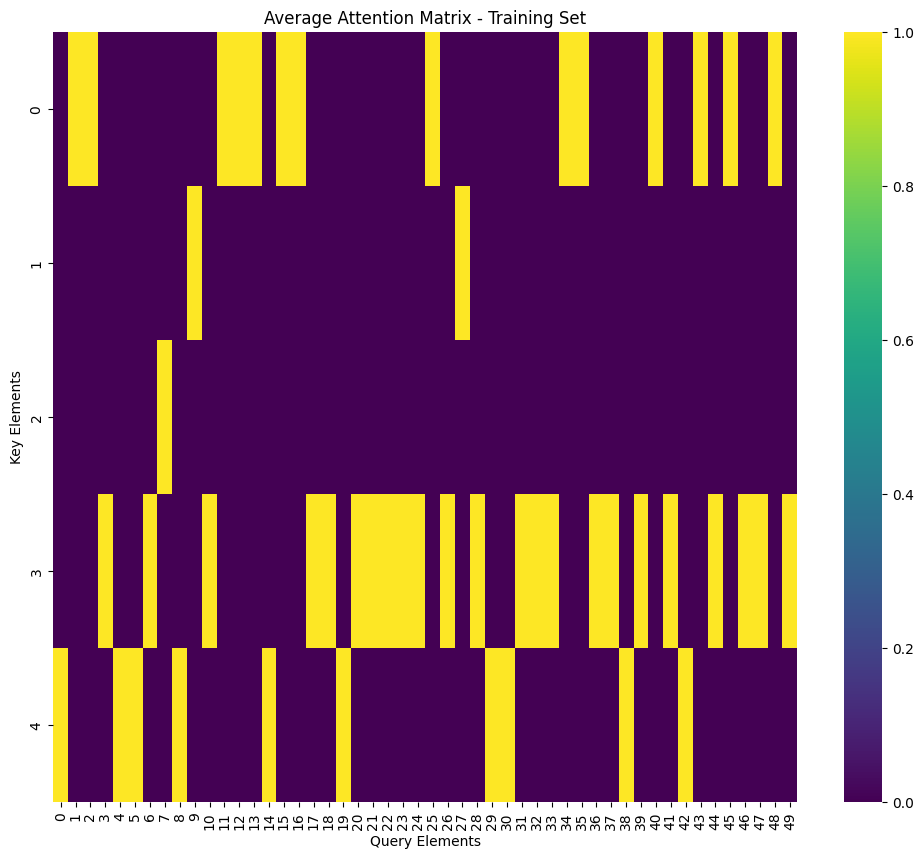

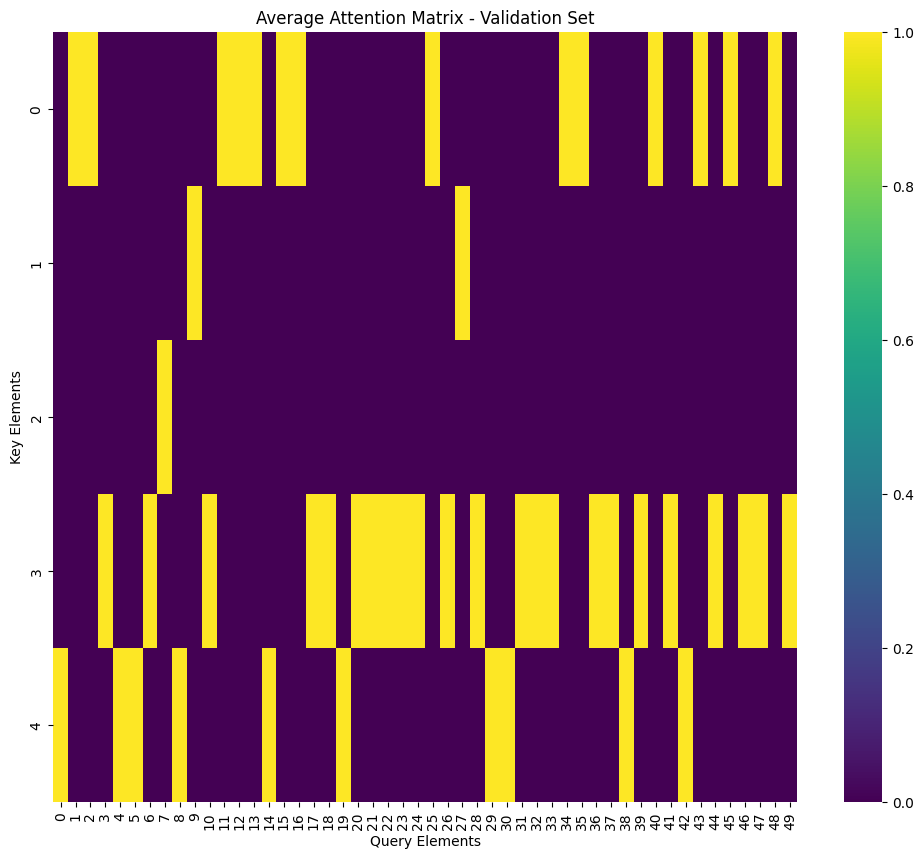

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_attention_heatmap(attn_matrix, title):
    plt.figure(figsize=(12, 10))
    sns.heatmap(attn_matrix, cmap='viridis')
    plt.title(title)
    plt.xlabel('Query Elements')  # Queries are now along X-axis
    plt.ylabel('Key Elements')    # Keys are now along Y-axis
    plt.show()

# Plot average attention matrices
plot_attention_heatmap(avg_attn_train_reordered, 'Average Attention Matrix - Training Set')
plot_attention_heatmap(avg_attn_val_reordered, 'Average Attention Matrix - Validation Set')
